# Natural Gas Price Prediction in Germany for 2025-2026
## Timeseries Analysis

### Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### EDA

In [5]:
gas_prices = pd.read_csv('nrg_pc_de.csv') #importing data
gas_prices = gas_prices.rename(columns={'TIME_PERIOD': 'date', 'OBS_VALUE': 'price'}) #renaming columns
gas_prices['date'] = pd.to_datetime(gas_prices['date'].str.replace('S1', '01-01').str.replace('S2', '07-01')) #converting to date
gas_prices.set_index('date', inplace = True) #setting date as index
gas_prices.asfreq('2AS').info() #setting time series frequency

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8 entries, 2008-01-01 to 2022-01-01
Freq: 2AS-JAN
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     8 non-null      object 
 1   LAST UPDATE  8 non-null      object 
 2   freq         8 non-null      object 
 3   product      8 non-null      int64  
 4   nrg_cons     8 non-null      object 
 5   unit         8 non-null      object 
 6   tax          8 non-null      object 
 7   currency     8 non-null      object 
 8   geo          8 non-null      object 
 9   price        8 non-null      float64
 10  OBS_FLAG     0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 768.0+ bytes


In [6]:
#removing unnecessary columns
columns_to_remove = ['DATAFLOW', 'LAST UPDATE', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'OBS_FLAG']

for i in columns_to_remove:
    del gas_prices[i]

In [7]:
gas_prices.head()

,price
date,
2007-07-01,0.0355
2008-01-01,0.0406
2008-07-01,0.0457
2009-01-01,0.0391
2009-07-01,0.0306


In [8]:
gas_prices.tail()

,price
date,
2021-07-01,0.0297
2022-01-01,0.0445
2022-07-01,0.0520
2023-01-01,0.0668
2023-07-01,0.0622


In [138]:
#looking for missing values
gas_prices.isna().sum()

price    0
dtype: int64

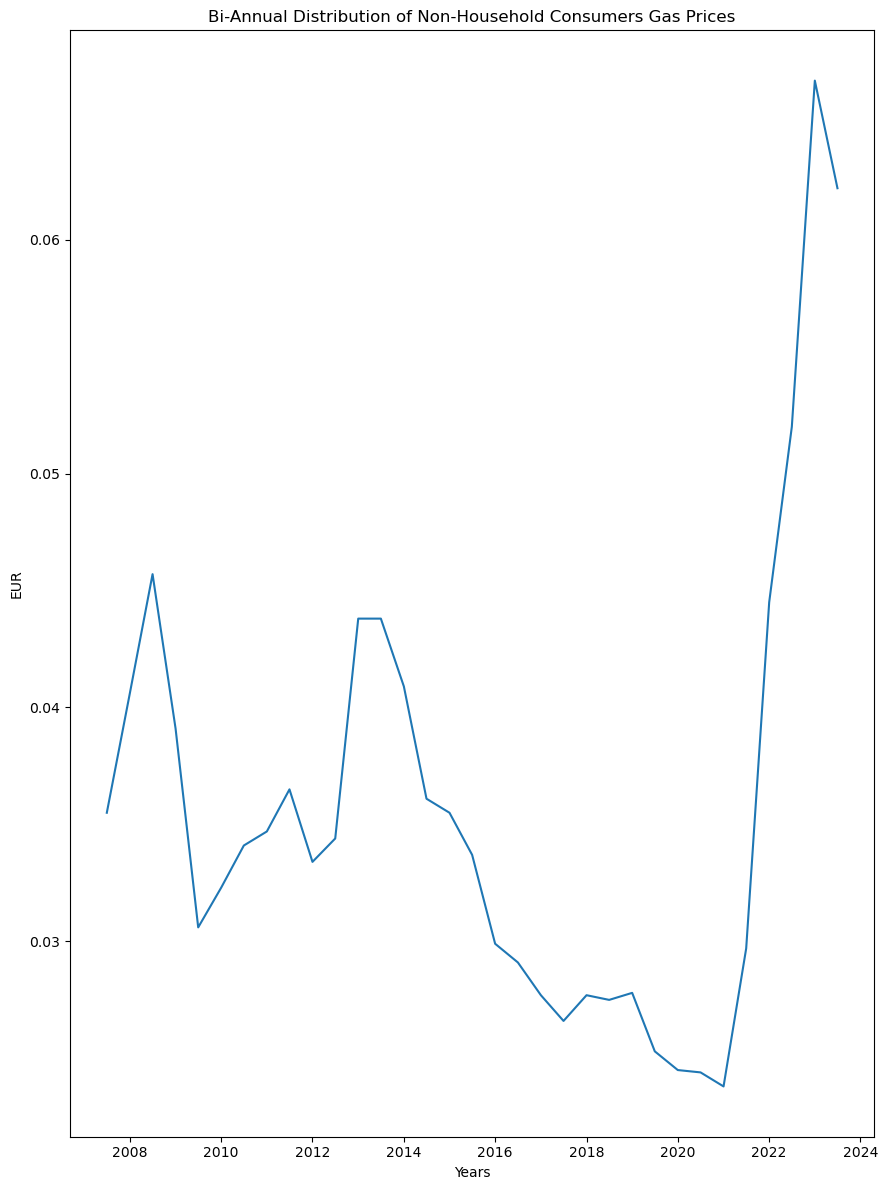

In [221]:
#creating a distribution of gas prices, the target variable

fig, ax = plt.subplots(figsize=(9,12))
sns.lineplot(x = gas_prices.index, y = 'price', data = gas_prices)
ax.set_ylabel('EUR')
ax.set_xlabel('Years')
ax.set_title('Bi-Annual Distribution of Non-Household Consumers Gas Prices')
plt.tight_layout()
plt.show()

In [12]:
gas_prices.describe()

,price
count,33.000000
mean,0.035764
std,0.010179
min,0.023800
25%,0.027800
50%,0.034100
75%,0.040600
max,0.066800


In [13]:
# Resampling
gas_prices_monthly = gas_prices.resample('MS').interpolate()
gas_prices_monthly.head()

,price
date,
2007-07-01,0.03550
2007-08-01,0.03635
2007-09-01,0.03720
2007-10-01,0.03805
2007-11-01,0.03890


## Investigating Seasonality, Trends, and Noise

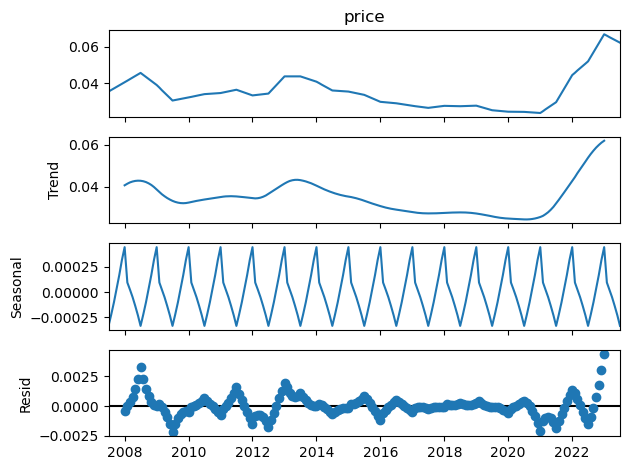

In [217]:
# Seasonal Decomposition
decomp_results=seasonal_decompose(gas_prices_monthly['price'], period=12)
decomp_results.plot()
plt.tight_layout()
plt.show()

In [16]:
result=adfuller(gas_prices_monthly['price'])
print(result)
print('The p-value for the ADF test is ', result[1])

(-2.3103615477531996, 0.16864794017565105, 7, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, -2287.368201085106)
The p-value for the ADF test is  0.16864794017565105


In [213]:
#first differencing
ts_diff = gas_prices_monthly.diff().dropna()

#ADF test
result=adfuller(ts_diff['price'])
print(result)
print('The p-value for the ADF test is ', result[1])


(-2.8410014882807175, 0.052651466341499566, 6, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, -2270.5071853353465)
The p-value for the ADF test is  0.052651466341499566


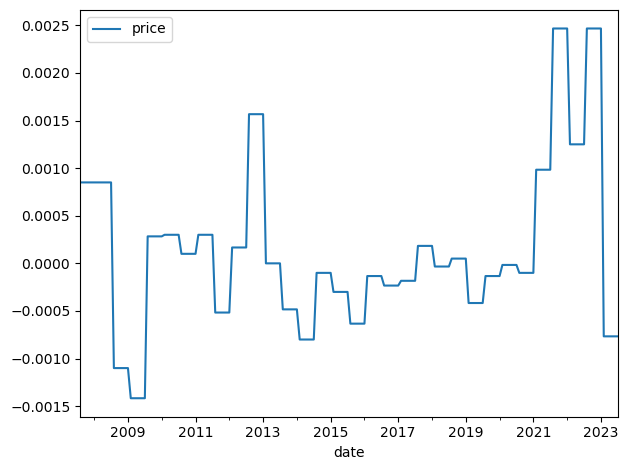

In [215]:
#plotting differenced timeseries
ts_diff.plot()
plt.tight_layout()
plt.show()

(-7.458828537768328, 5.4216232849367875e-11, 5, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, -2251.478016838414)
The p-value for the ADF test is  5.4216232849367875e-11


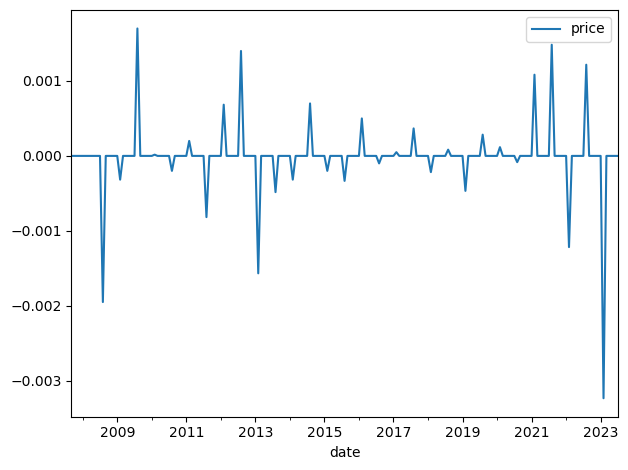

In [209]:
#Second differencing
ts_diff=gas_prices_monthly.diff().diff().dropna()

result=adfuller(ts_diff['price'])
print(result)
print('The p-value for the ADF test is ', result[1])
ts_diff.plot()
plt.tight_layout()
plt.show()

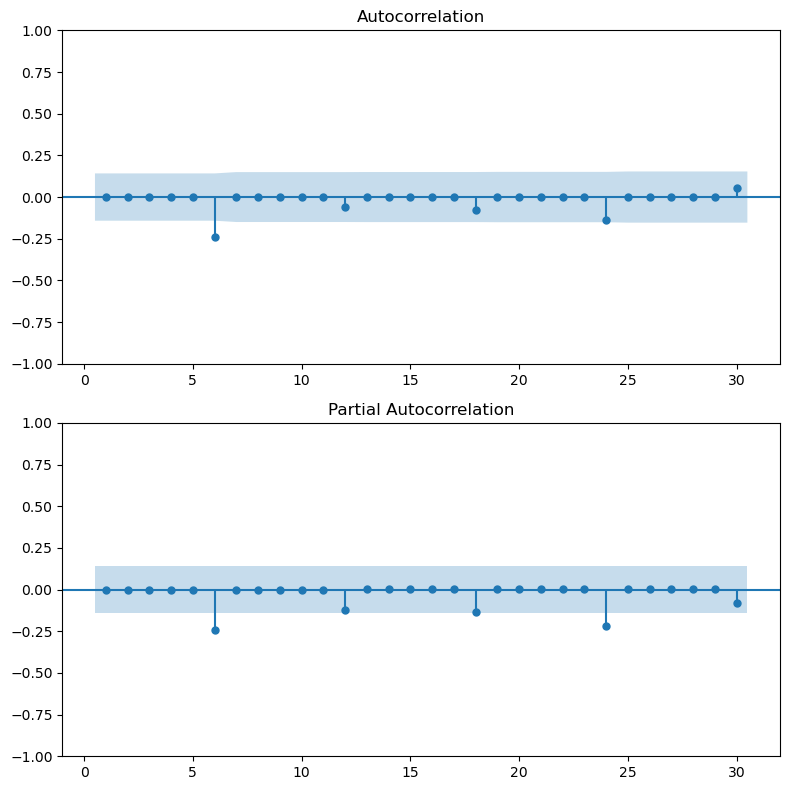

In [207]:
# ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(ts_diff, lags=30, zero=False, ax=ax1)
plot_pacf(ts_diff, lags=30, zero=False, ax=ax2)
plt.tight_layout()
plt.show()

In [148]:
# Finding p & q

order_aic_bic=[]
#Loop over AR order
for p in range(5):
    #Loop over MA order
    for q in range(5):
        #fit model
        model=ARIMA(gas_prices_monthly, order=(p, 2, q))
        results=model.fit()
        #Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])
print(order_df.sort_values('AIC'))
                

    p  q          AIC          BIC
0   0  0 -2442.294621 -2439.042347
5   1  0 -2440.301281 -2433.796734
1   0  1 -2440.299613 -2433.795066
6   1  1 -2438.299613 -2428.542792
10  2  0 -2438.299613 -2428.542792
2   0  2 -2438.259634 -2428.502814
11  2  1 -2436.299613 -2423.290519
15  3  0 -2436.299010 -2423.289917
3   0  3 -2436.259634 -2423.250540
7   1  2 -2436.259634 -2423.250540
16  3  1 -2434.299613 -2418.038245
20  4  0 -2434.299613 -2418.038245
4   0  4 -2434.279354 -2418.017986
8   1  3 -2434.259634 -2417.998267
12  2  2 -2434.259634 -2417.998267
9   1  4 -2432.279354 -2412.765713
13  2  3 -2432.270339 -2412.756699
17  3  2 -2432.259634 -2412.745993
21  4  1 -2432.231698 -2412.718058
14  2  4 -2430.279354 -2407.513440
18  3  3 -2430.259634 -2407.493720
22  4  2 -2430.259634 -2407.493720
19  3  4 -2428.279354 -2402.261166
23  4  3 -2428.259634 -2402.241446
24  4  4 -2426.279354 -2397.008893


In [150]:
#Model Diagnostics

model=ARIMA(gas_prices_monthly, order=(0,2,0))
results=model.fit()
print(results.summary())
residuals=results.resid
mae=np.mean(np.abs(residuals))
print(mae)

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  193
Model:                 ARIMA(0, 2, 0)   Log Likelihood                1222.147
Date:                Mon, 07 Oct 2024   AIC                          -2442.295
Time:                        15:57:30   BIC                          -2439.042
Sample:                    07-01-2007   HQIC                         -2440.977
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.604e-07   4.25e-09     37.775      0.000    1.52e-07    1.69e-07
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6206.42
Prob(Q):                              1.00   Pr

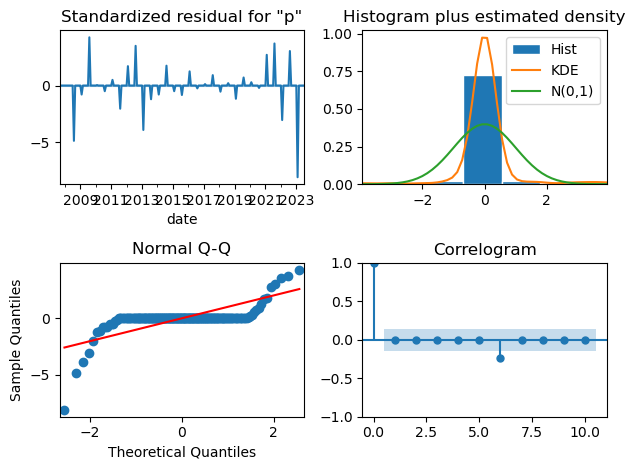

In [195]:
#Plotting Diagnostics
results.plot_diagnostics()
plt.tight_layout()
plt.show()

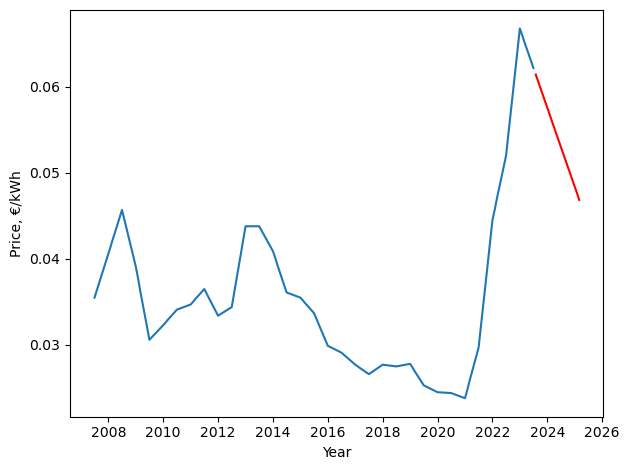

In [197]:
# ARIMA model
model = ARIMA(gas_prices_monthly, order=(0,2,0))
resultat=model.fit()

forecast=resultat.get_forecast(steps=20)
mean_forecast=forecast.predicted_mean
confidence_intervals=forecast.conf_int()

plt.figure()
plt.plot(gas_prices_monthly.index, gas_prices_monthly, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='red', label='forecast')
plt.xlabel('Year')
plt.ylabel('Price, €/kWh')
plt.tight_layout()
plt.show()

## Model Preparation

In [157]:
def train_test(dataframe):
    """
    This function splits the data into 
    train test split
    """
    #splitting the data into train/test
    cutoff = round(dataframe.shape[0]*0.98)


    train = dataframe[:cutoff] #everything up to the cutoff
    test = dataframe[cutoff:] #cutoff up
    return train, test, cutoff

In [159]:
train, test, cutoff = train_test(gas_prices_monthly)
len(train)

189

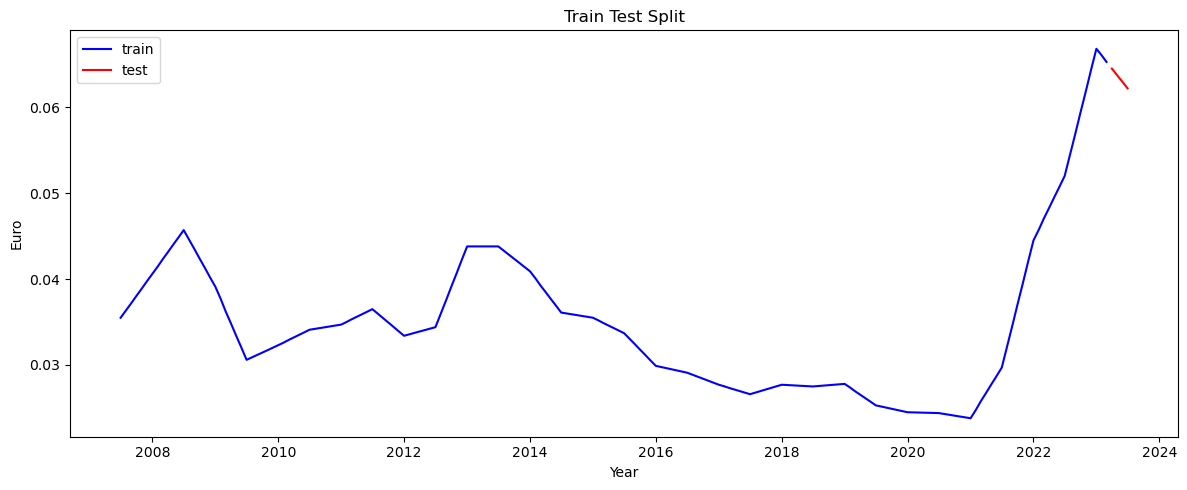

In [201]:
#plotting the train and test split of our data
fig, ax = plt.subplots(figsize=(12,5))
labels = ['train', 'test']
plot_train = ax.plot(train, color='blue')
plot_test = ax.plot(test, color='red')
ax.legend(labels)
ax.set_xlabel('Year')
ax.set_ylabel('Euro')
ax.set_title('Train Test Split')
plt.tight_layout()
plt.show()

In [163]:
# ARIMA model training
ar = ARIMA(train, order=(2, 1, 1)).fit()
train_yhat_ar = ar.predict(typ='levels', dynamic=False)
train_yhat_ar.tail()

date
2022-11-01    0.059400
2022-12-01    0.061867
2023-01-01    0.064333
2023-02-01    0.066800
2023-03-01    0.066033
Freq: MS, Name: predicted_mean, dtype: float64

In [165]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  189
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1055.808
Date:                Mon, 07 Oct 2024   AIC                          -2103.616
Time:                        15:57:39   BIC                          -2090.670
Sample:                    07-01-2007   HQIC                         -2098.371
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.423e-06      0.065   3.75e-05      1.000      -0.127       0.127
ar.L2       2.121e-06      0.125   1.69e-05      1.000      -0.246       0.246
ma.L1       2.423e-06      0.065   3.75e-05      1.000      -0.127       0.127
sigma2      7.673e-07   1.12e-07      6.872      0.000    5.48e-07    9.86e-07
===================================================================================
Ljung-Box (L1) (Q):                 149.79   Jarque-Bera (JB):                45.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+16. Standard errors may be unstable.
"""

In [167]:
artrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_ar))
artrain_rmse

0.0027274993233199884

In [203]:
def predictions_graph(predictions, data):
    """
    This function takes in the predictions and data (train or test) outputs
    2 graphs, 1 of the predictions, and 1 of the predictions zoomed in.
    """
    fig, axes = plt.subplots(figsize=(17, 5))
    
    labels=['Original', 'Prediction']
    
    axes.plot(data)
    axes.set_ylabel('US Dollars')
    axes.set_xlabel('Year')
    axes.plot(predictions)
    axes.set_title('Predictions')
    axes.legend(labels)
    plt.tight_layout()
    plt.show()

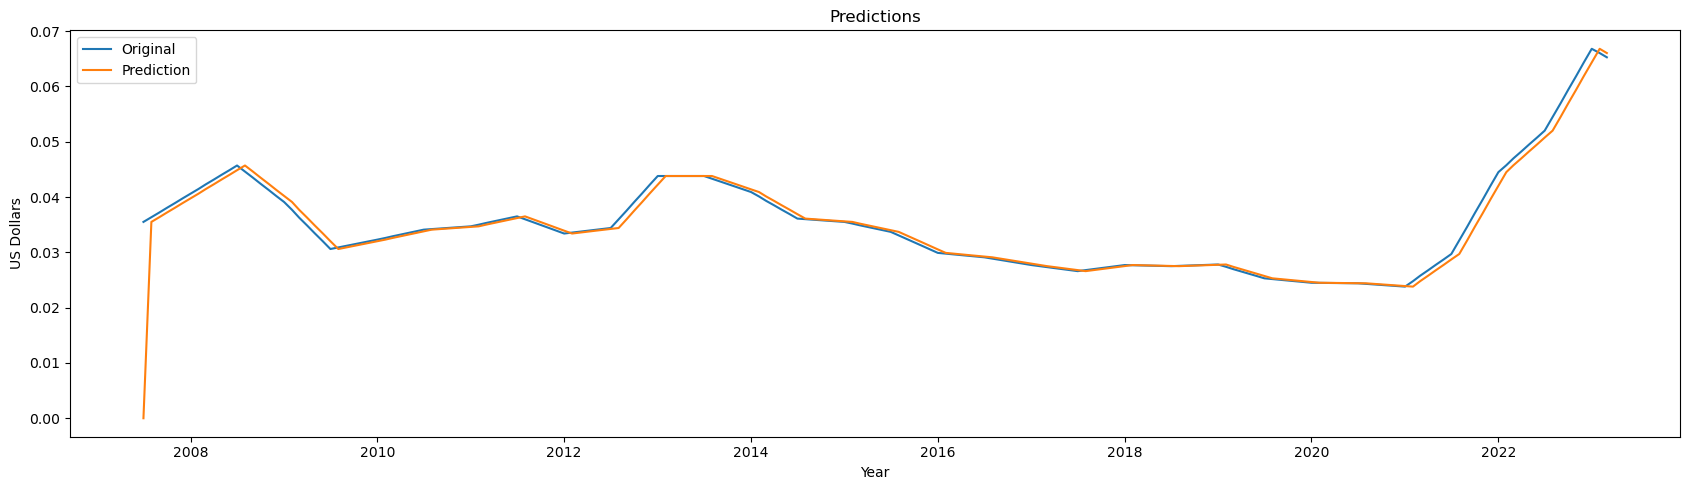

In [205]:
predictions_graph(train_yhat_ar, train)

In [173]:
test.head()

,price
date,
2023-04-01,0.064500
2023-05-01,0.063733
2023-06-01,0.062967
2023-07-01,0.062200


In [175]:
#getting predictions on the test
test_yhat_ar = ar.predict(start = test.index[0],end = test.index[-1],typ='levels')

In [72]:
#RMSE Value
artest_rmse = np.sqrt(mean_squared_error(test, test_yhat_ar))
artest_rmse

0.002099596924377463

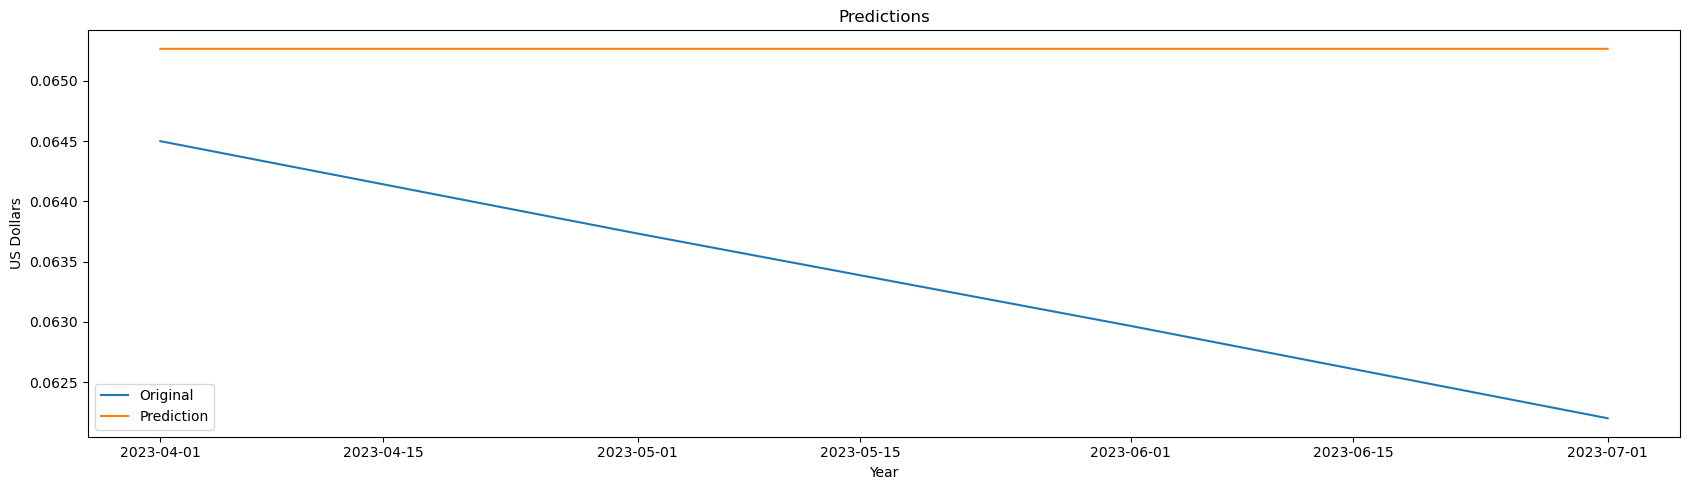

In [74]:
predictions_graph(test_yhat_ar, test)

## SARIMA model

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [79]:
#utilizing auto_arima to assess the ideal parameters

pm.auto_arima(train, seasonal=True, m=12, n_jobs=-1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  189
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1212.557
Date:                Mon, 07 Oct 2024   AIC                          -2417.113
Time:                        15:45:24   BIC                          -2404.146
Sample:                    07-01-2007   HQIC                         -2411.860
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.266      0.023     4.7e-05       0.001
ar.L1          1.9212      0.037     51.407      0.000       1.848       1.994
ar.L2         -0.9311      0.040    -23.463      0.000      -1.009      -0.853
sigma2      1.498e-07    8.2e-09     18.278      0.000    1.34e-07    1.66e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2893.15
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -1.43
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
# Searching Parameters

results = pm.auto_arima(train,
                        d=1,
                        start_p=0,
                        start_q=0,
                        max_p=5,
                        max_q=5,
                        seasonal=True,
                        m=12,
                        D=1,
                        start_P=0,
                        start_Q=0,
                        max_P=3,
                        max_Q=3,
                        information_criterion='aic',
                        trace=True,
                        error_action='ignore',
                        stepwise=True
                       )
results
                        


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1904.718, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2183.770, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2058.223, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-2156.537, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-2194.110, Time=0.73 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-2191.353, Time=1.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-2181.653, Time=1.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-2173.176, Time=0.54 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=-2179.600, Time=2.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1939.454, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-2192.801, Time=1.12 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-2192.675, Time=1.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-2068.817, Time=0.93 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-2194.746, Time=1.61 sec
 ARIM

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [81]:
sr = SARIMAX(train,
             order=(2,1,1),
             seasonal_order=(2,1,0,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.82011D+00    |proj g|=  4.75650D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -5.83795D+00    |proj g|=  2.63988D+01
  ys=-1.211E-05  -gs= 1.126E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     84      3     1     0   2.640D+01  -5.838D+00
  F =  -5.8379532780141457     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [82]:
#getting predictions on the train
train_yhat_sr = sr.predict(typ='levels')
train_yhat_sr.tail()

date
2022-11-01    0.061613
2022-12-01    0.064077
2023-01-01    0.066541
2023-02-01    0.068491
2023-03-01    0.065134
Freq: MS, Name: predicted_mean, dtype: float64

In [83]:
sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                  189
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood                1103.373
Date:                             Mon, 07 Oct 2024   AIC                          -2194.746
Time:                                     15:45:52   BIC                          -2175.723
Sample:                                 07-01-2007   HQIC                         -2187.031
                                      - 03-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9116      0.032     59.088      0.000       1.848       1.975
ar.L2         -0.9245      0.036    -25.387      0.000      -0.996      -0.853
ma.L1         -0.9845      0.011    -90.935      0.000      -1.006      -0.963
ar.S.L12      -0.3829      0.037    -10.483      0.000      -0.454      -0.311
ar.S.L24      -0.1844      0.048     -3.876      0.000      -0.278      -0.091
sigma2      1.956e-07   1.41e-08     13.906      0.000    1.68e-07    2.23e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              2462.60
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.66
Prob(H) (two-sided):                  0.29   Kurtosis:                        21.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+17. Standard errors may be unstable.
"""

In [84]:
#RMSE Value
srtrain_rmse = np.sqrt(mean_squared_error(train, train_yhat_sr))
srtrain_rmse

0.002904612026647684

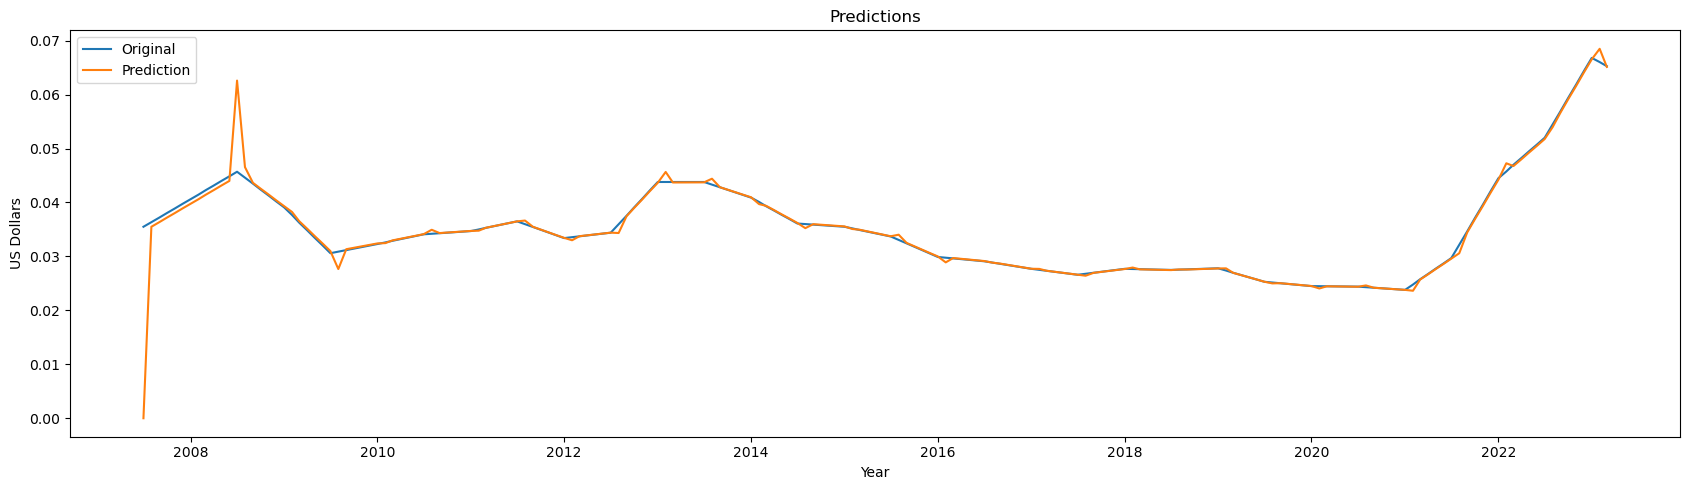

In [86]:
predictions_graph(train_yhat_sr, train)

In [87]:
test.head()

,price
date,
2023-04-01,0.064500
2023-05-01,0.063733
2023-06-01,0.062967
2023-07-01,0.062200


In [88]:
#getting predictions on the test
test_yhat_sr = sr.predict(start = test.index[0],end = test.index[-1], dynamic= False)

In [89]:
#RMSE Value
srtest_rmse = np.sqrt(mean_squared_error(test, test_yhat_sr))
srtest_rmse

0.00047593497869250384

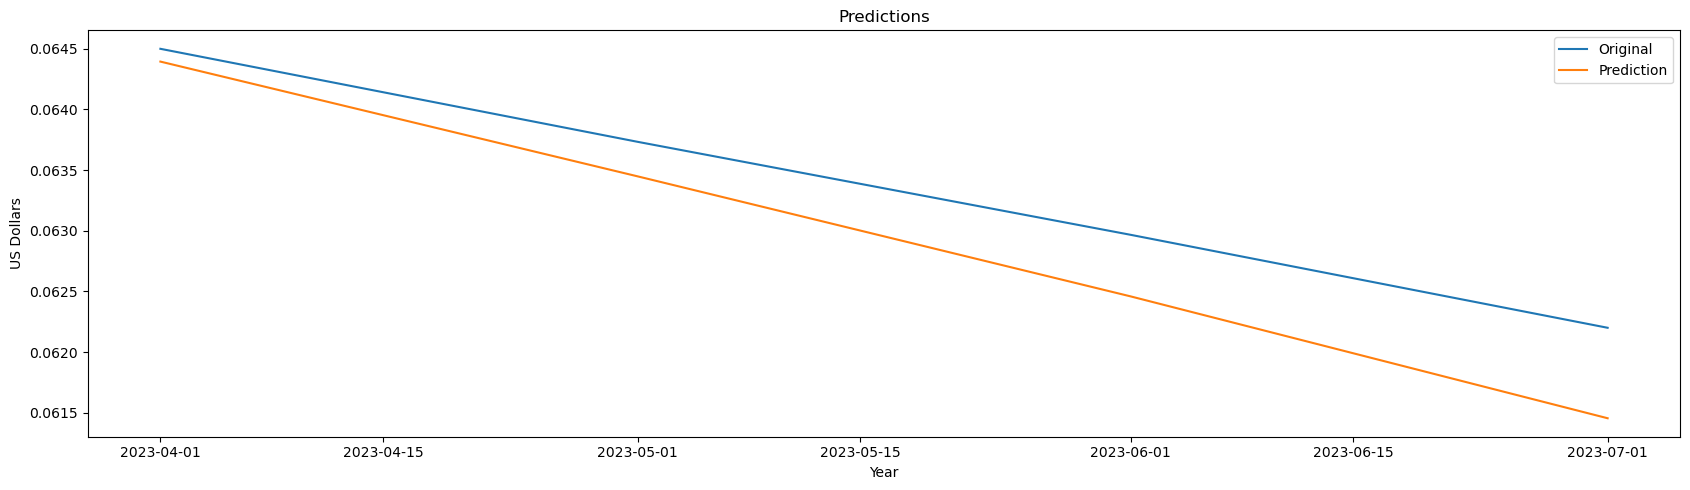

In [90]:
predictions_graph(test_yhat_sr, test)

## Facebook Prophet

In [92]:
#importing Prophet for Facebook Prophet
from prophet import Prophet

In [93]:
#getting the dataframe for Prophet according to it's specifications
ts_for_fb = gas_prices_monthly.reset_index()
ts_for_fb.rename(columns = {'date':'ds', 'price':'y'}, inplace = True)
ts_for_fb.head()

,ds,y
0,2007-07-01,0.03550
1,2007-08-01,0.03635
2,2007-09-01,0.03720
3,2007-10-01,0.03805
4,2007-11-01,0.03890


In [94]:
#doing a train test split on the dataset

train_fb = ts_for_fb[:cutoff] #everything up to the cutoff
test_fb = ts_for_fb[cutoff:] #cutoff up

In [95]:
#instantiating and fitting the model
prophet_model = Prophet()
prophet_model.fit(train_fb);

15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
#getting the train predictions
train_yhat_fb = prophet_model.predict(train_fb)
train_yhat_fb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
184,2022-11-01,0.050442,0.045591,0.056859,0.050442,0.050442,0.000646,0.000646,0.000646,0.000646,0.000646,0.000646,0.0,0.0,0.0,0.051087
185,2022-12-01,0.051165,0.046373,0.057680,0.051165,0.051165,0.000805,0.000805,0.000805,0.000805,0.000805,0.000805,0.0,0.0,0.0,0.051970
186,2023-01-01,0.051912,0.046404,0.058589,0.051912,0.051912,0.000934,0.000934,0.000934,0.000934,0.000934,0.000934,0.0,0.0,0.0,0.052846
187,2023-02-01,0.052659,0.047767,0.059330,0.052659,0.052659,0.000695,0.000695,0.000695,0.000695,0.000695,0.000695,0.0,0.0,0.0,0.053353
188,2023-03-01,0.053334,0.049929,0.061673,0.053334,0.053334,0.002080,0.002080,0.002080,0.002080,0.002080,0.002080,0.0,0.0,0.0,0.055414


In [112]:
#RMSE Value
fbtrain_rmse = np.sqrt(mean_squared_error(train_fb['y'], train_yhat_fb['yhat']))
fbtrain_rmse

0.0046217024302018985

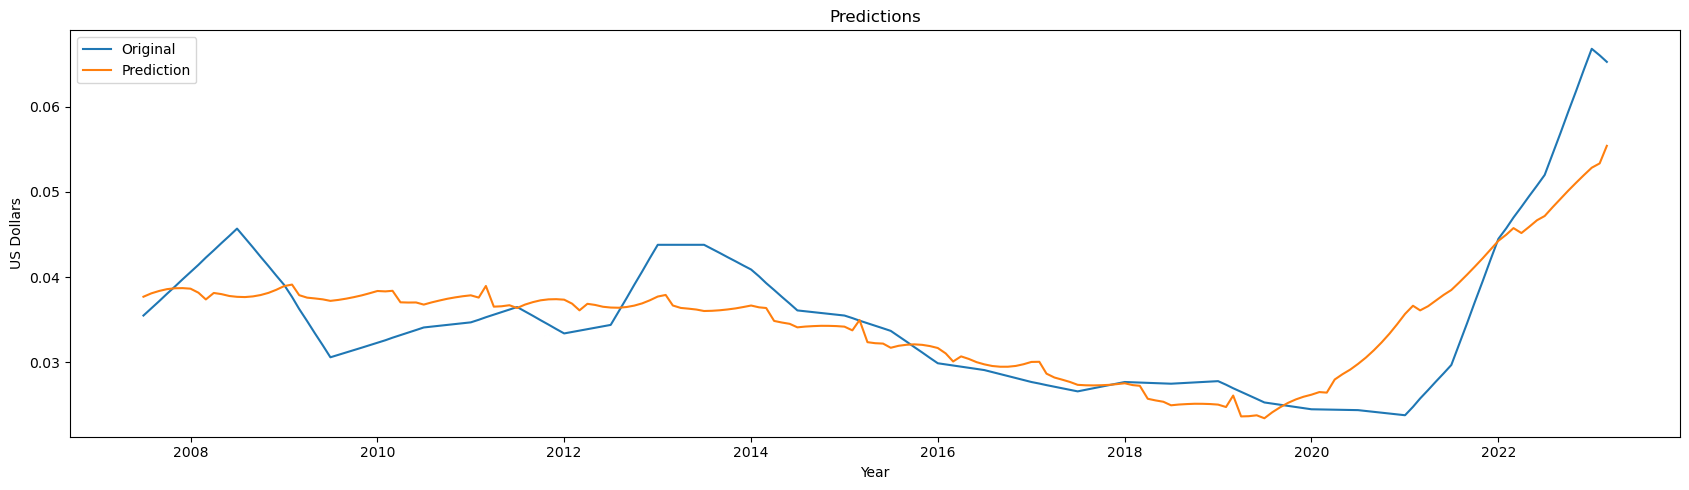

In [114]:
predictions_graph(train_yhat_fb.set_index('ds')['yhat'], train_fb.set_index('ds')['y'])

In [116]:
test_fb.head()

,ds,y
189,2023-04-01,0.064500
190,2023-05-01,0.063733
191,2023-06-01,0.062967
192,2023-07-01,0.062200


In [118]:
#getting the test predictions
test_yhat_fb = prophet_model.predict(test_fb)
test_yhat_fb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-01,0.054081,0.047837,0.059737,0.054081,0.054081,-0.000324,-0.000324,-0.000324,-0.000324,-0.000324,-0.000324,0.0,0.0,0.0,0.053756
1,2023-05-01,0.054804,0.048463,0.060777,0.054794,0.054810,-0.000256,-0.000256,-0.000256,-0.000256,-0.000256,-0.000256,0.0,0.0,0.0,0.054548
2,2023-06-01,0.055551,0.049451,0.061270,0.055511,0.055577,-0.000108,-0.000108,-0.000108,-0.000108,-0.000108,-0.000108,0.0,0.0,0.0,0.055443
3,2023-07-01,0.056274,0.050022,0.062002,0.056199,0.056340,-0.000411,-0.000411,-0.000411,-0.000411,-0.000411,-0.000411,0.0,0.0,0.0,0.055863


In [120]:
#RMSE Value
fbtest_rmse = np.sqrt(mean_squared_error(test_fb['y'], test_yhat_fb['yhat']))
fbtest_rmse

0.008610674832338343

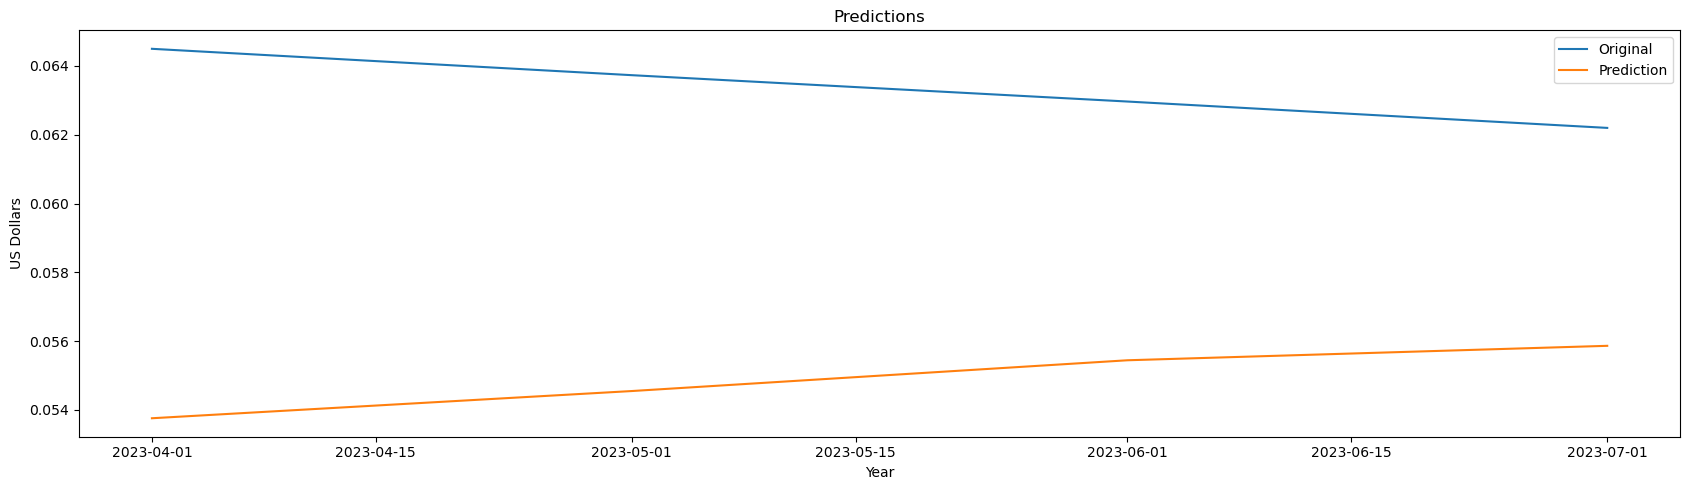

In [122]:
predictions_graph(test_yhat_fb.set_index('ds')['yhat'], test_fb.set_index('ds')['y'])

## Model Selection & Deployment

In [125]:
rmse_results = pd.DataFrame({'Model': ['ARIMA', 'SARIMAX', 'FB PROPHET'],
                            'Train_RMSE': [artrain_rmse, srtrain_rmse, fbtrain_rmse],
                            'Test_RMSE': [artest_rmse, srtest_rmse, fbtest_rmse]})
rmse_results

,Model,Train_RMSE,Test_RMSE
0,ARIMA,0.002727,0.002100
1,SARIMAX,0.002905,0.000476
2,FB PROPHET,0.004622,0.008611


In [127]:
print(rmse_results[rmse_results.Test_RMSE == rmse_results.Test_RMSE.min()])

     Model  Train_RMSE  Test_RMSE
1  SARIMAX    0.002905   0.000476


In [133]:
#Fitting the final model

model = SARIMAX(gas_prices_monthly,
             order=(2,1,1),
             seasonal_order=(2,1,0,12))

model_fit = model.fit()

# Generate future dates for prediction
future_dates = pd.date_range(start=gas_prices_monthly.index[-1], periods=24, freq='MS')  # 12 months

# Forecast using fitted model
forecast = model_fit.forecast(steps=24)

# Print the last 24 forecast values (or forecast_df for full view)
print(forecast[-24:])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.53897D+00    |proj g|=  4.47881D+03


 This problem is unconstrained.



At iterate    5    f= -5.14032D+00    |proj g|=  1.35443D+01
  ys=-3.018E-07  -gs= 1.733E-06 BFGS update SKIPPED

At iterate   10    f= -5.14033D+00    |proj g|=  1.49400D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     42      1     1     0   1.494D+00  -5.140D+00
  F =  -5.1403344908510702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2023-08-01    0.064012
2023-09-01    0.065824
2023-10-01    0.067636
2023-11-01    0.069448
2023-12-01    0.071260
2024-01-01    0.073072
2024-02-01    0.073114
2024-03-01    0.073156
2024-04-01    0.073199
2024-05-01    0.073241
2024-06-01    0.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


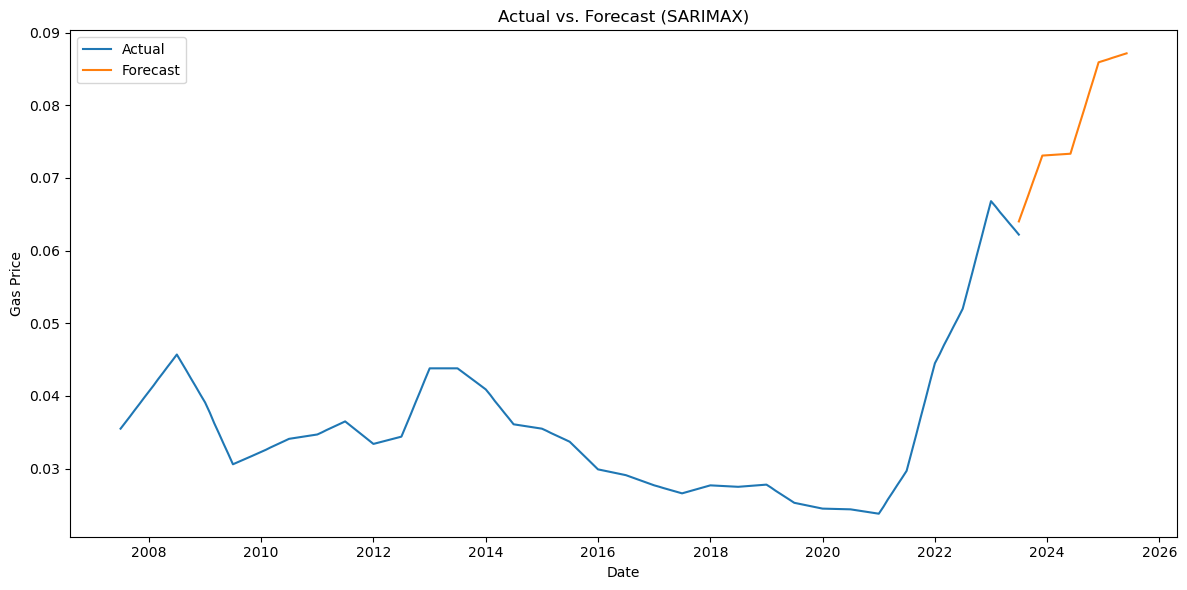

In [131]:
#plotting
forecast_df = pd.DataFrame({'date': future_dates, 'forecast': forecast})

# Plot actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(gas_prices_monthly.index, gas_prices_monthly.values, label='Actual')
plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Actual vs. Forecast (SARIMAX)')
plt.legend()
plt.tight_layout()  # Adjust spacing for better layout
plt.show()

In [223]:
plt.savefig('gas_price_forecast.png')

<Figure size 640x480 with 0 Axes>